### Experiments with training different dataset 

Goal is to see if training on high freq leads to better performance on low freq dataset than training on low freq dataset for high freq data  

8/19

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [2]:
save = False

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [7]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [8]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [9]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

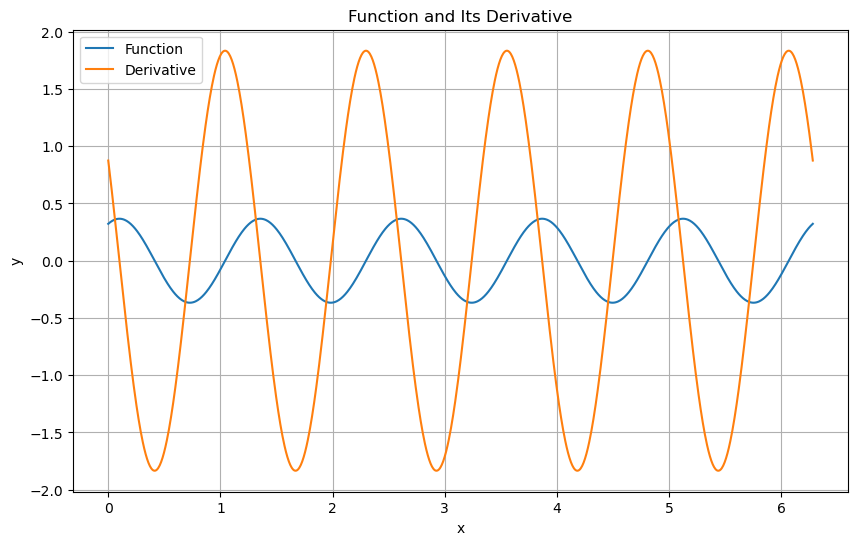

In [10]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [13]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [14]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [15]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [16]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Tests to see model output frequencies

In [131]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print(3)


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 20)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()


lim: 18


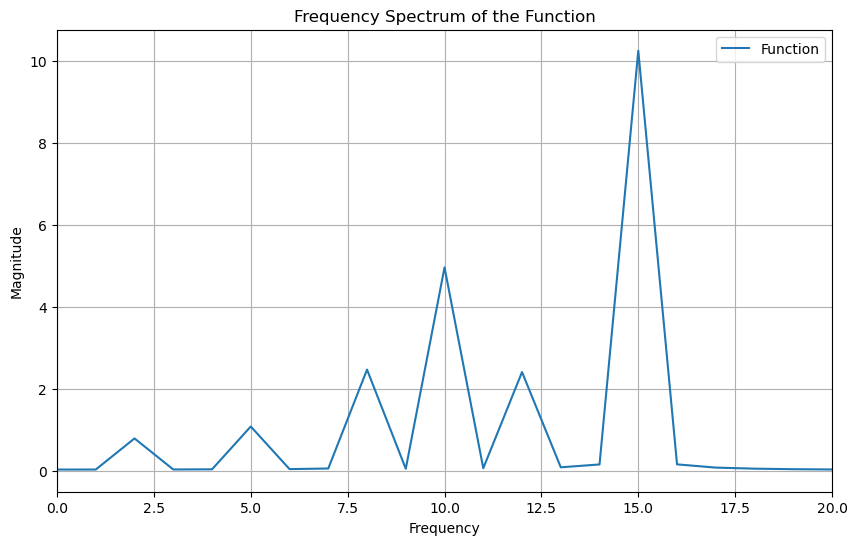

In [132]:
a = np.random.randint(0, 32)
function = test_dataset_g[a][0]
derivative = test_dataset_g[a][1]

plot_frequencies(derivative)

In [133]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

L3ModelK3_untrained = SimpleCNN(n_layers=3, kernel_size=3)

lim: 18


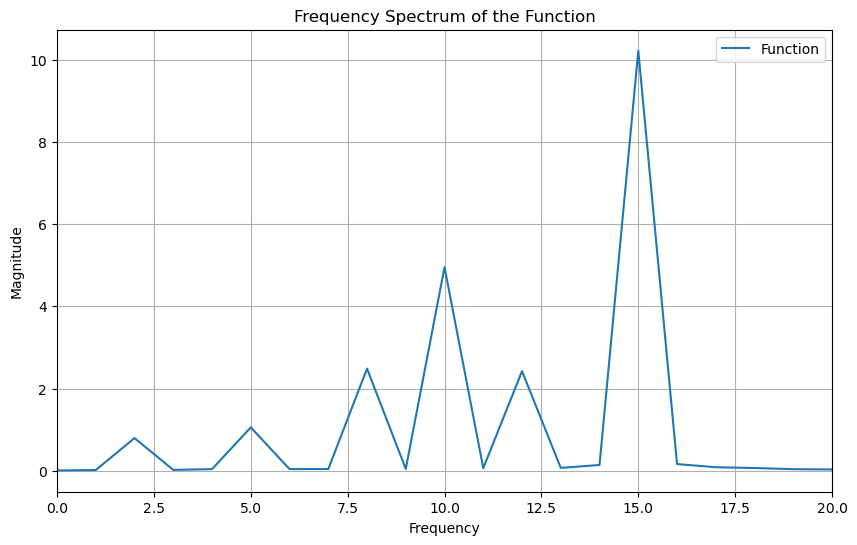

In [134]:
function1 = function.unsqueeze(0)
output = L3ModelK3(function1).squeeze()
plot_frequencies(output)

3
lim: 18


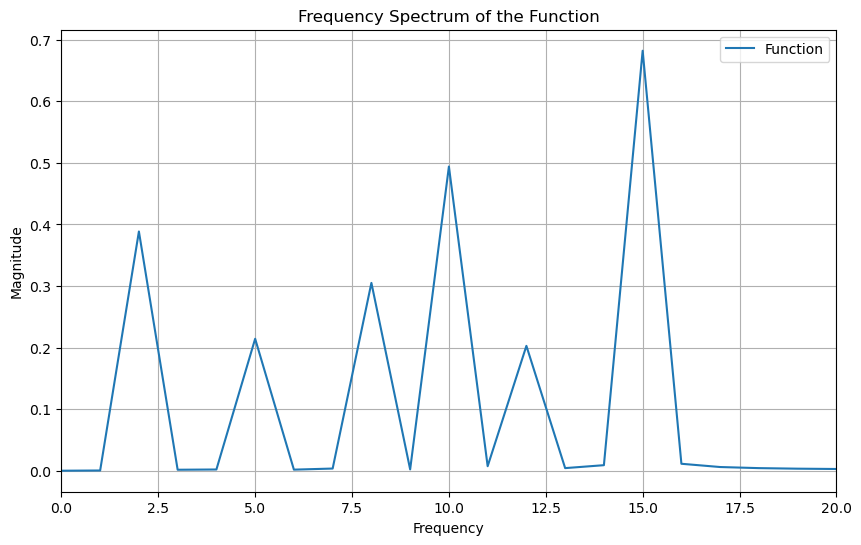

In [135]:
plot_frequencies(function=function, derivative=derivative, residue=True, model=L3ModelK3)

lim: 18


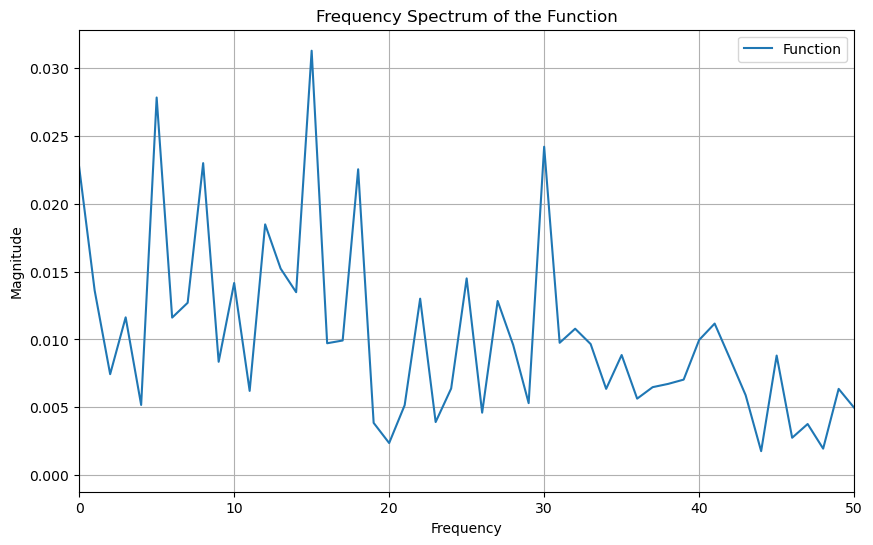

In [88]:
plot_frequencies(derivative - output)

## Function to train model

In [42]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define a new loss function that can use NMSE
    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [43]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [44]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [45]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [46]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

## Plot results

In [47]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [156]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            print("Showing ground truth derivative")
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            print("Showing model output")

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model: # If you only want the residue
            
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)

            F_derivatives = torch.fft.fft(derivatives)

            residues = F_derivatives - F_outputs
            print("Showing residues")
            F = residues
            # print(f"F is: {F}")

        else:
            print("Showing u_g")
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0, sort=True):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    if sort:
    # Sort functions by dominant frequency
        sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        sorted_fft = fft_amplitudes

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [157]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None, all=True, sort=True):
    if all: # Plot all three datasets
        fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_l,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label}', xmin=0, xmax=6, sort=sort)

        fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label}', xmin=0, xmax=16, sort=sort)

        fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_h,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label}', xmin=10, xmax=16, sort=sort)

    else: # Plot only the general frequency dataset
        fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label}', xmin=0, xmax=16, sort=sort)


In [158]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None, residue=False):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-5

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    plot_heatmaps(model=model, label=f'first', all=False)
    plt.show()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0


        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # If iteration reached, then plot the colormap once
        if (epoch) % split_freq == 0:
            print(f"Plotting the colormap once at iteration {epoch}")
            label = epoch // split_freq

            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

            plot_heatmaps(model=model, label=f'{label}', all=False, residue=residue)

            plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

Showing residues
Showing residues
Showing residues


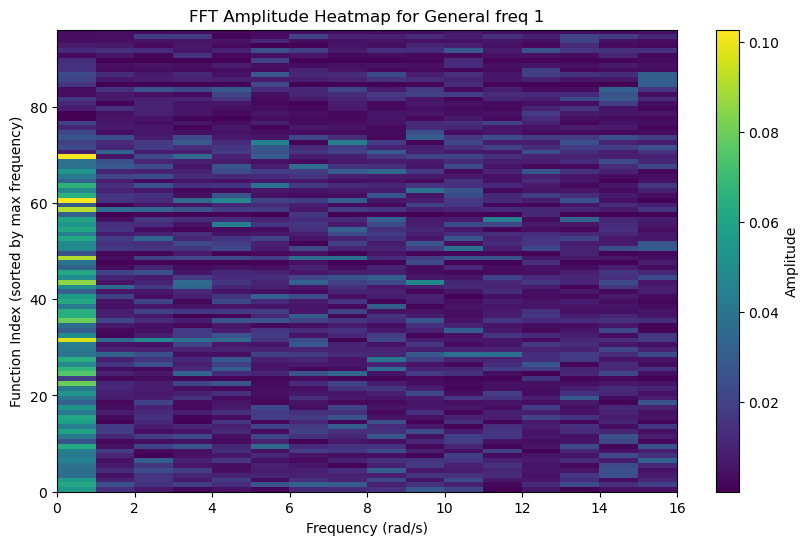

In [159]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
plot_heatmaps(model=L3ModelK3, residue=True, label=f'{1}', all=False, sort=True)


1
Showing model output
Showing model output
Showing model output


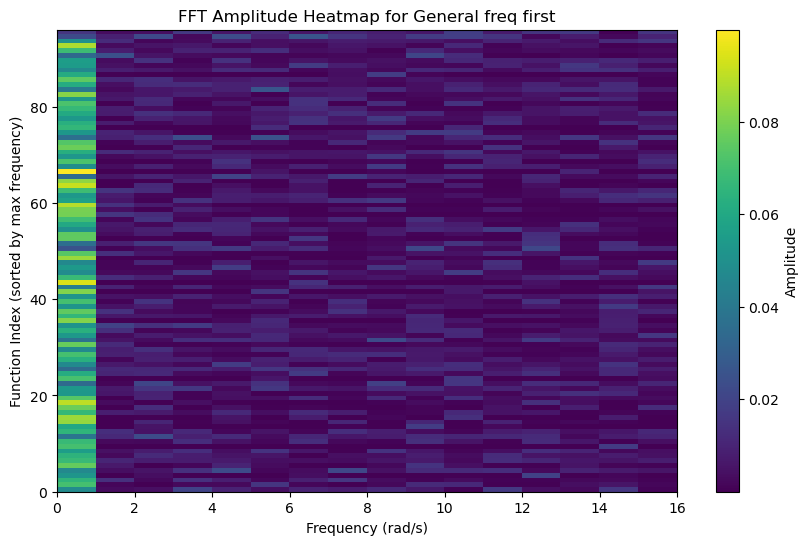

Epoch [1/500], Train Loss: 18.5226, Test Loss: 20.2916
Plotting the colormap once at iteration 0
Showing residues
Showing residues
Showing residues


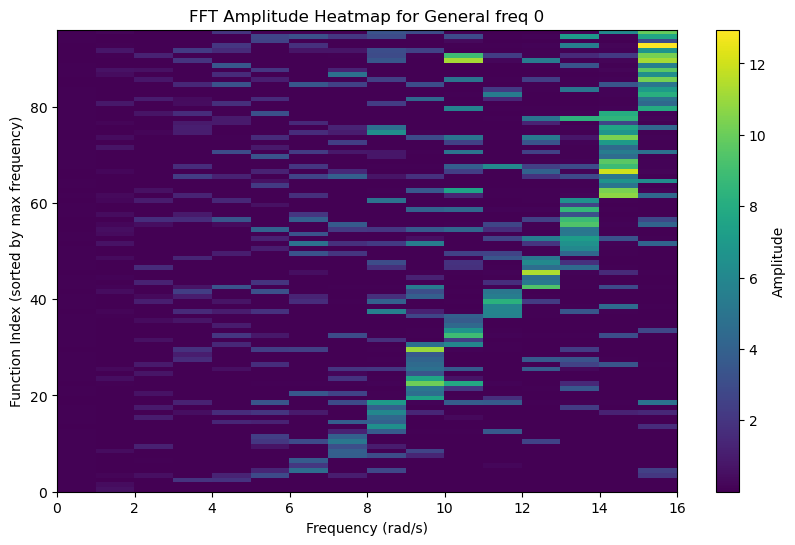

Epoch [2/500], Train Loss: 18.3495, Test Loss: 20.2869
Plotting the colormap once at iteration 1
Showing residues
Showing residues
Showing residues


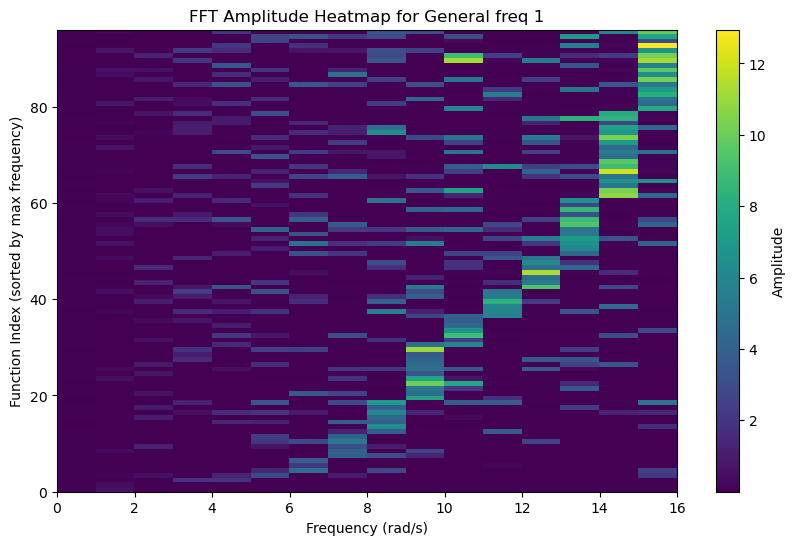

Epoch [3/500], Train Loss: 18.1732, Test Loss: 20.2821
Plotting the colormap once at iteration 2
Showing residues
Showing residues
Showing residues


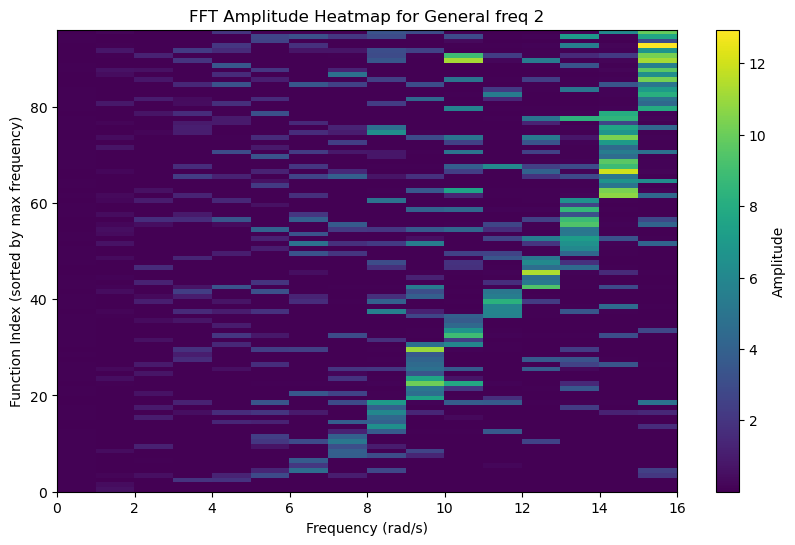

Epoch [4/500], Train Loss: 18.3108, Test Loss: 20.2774
Plotting the colormap once at iteration 3
Showing residues
Showing residues
Showing residues


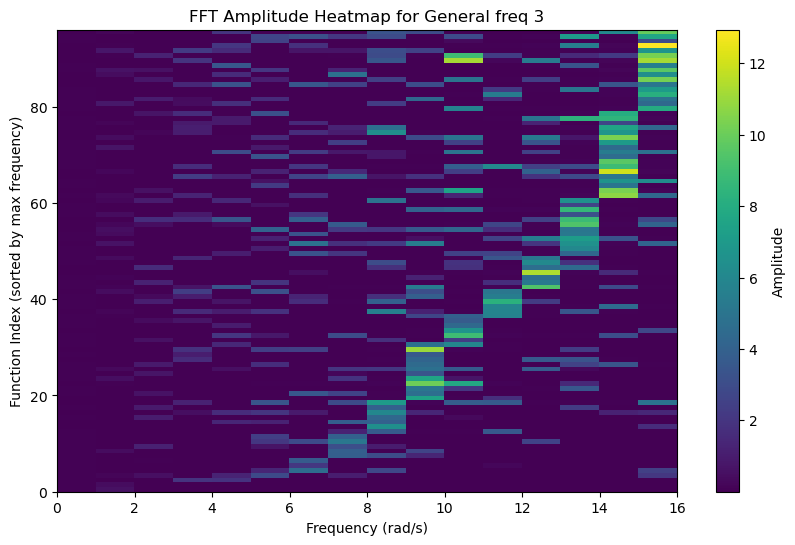

Epoch [5/500], Train Loss: 18.0625, Test Loss: 20.2727
Plotting the colormap once at iteration 4
Showing residues
Showing residues
Showing residues


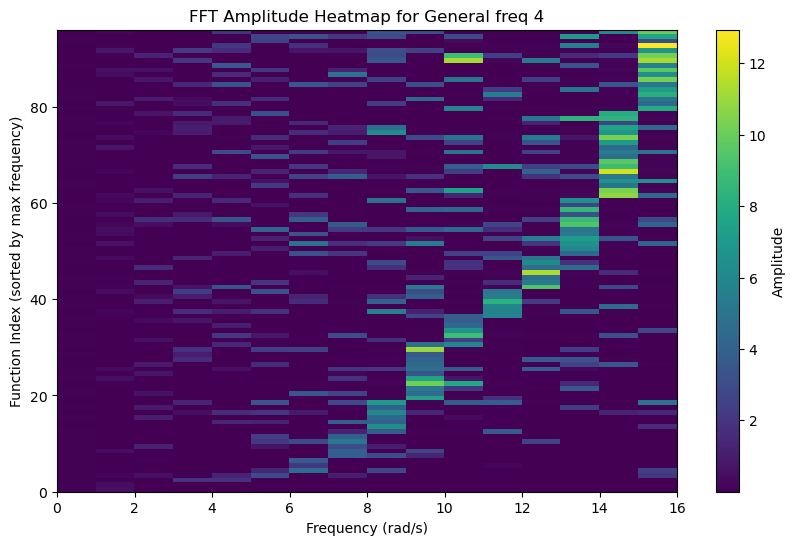

Epoch [6/500], Train Loss: 18.3489, Test Loss: 20.2682
Plotting the colormap once at iteration 5
Showing residues
Showing residues
Showing residues


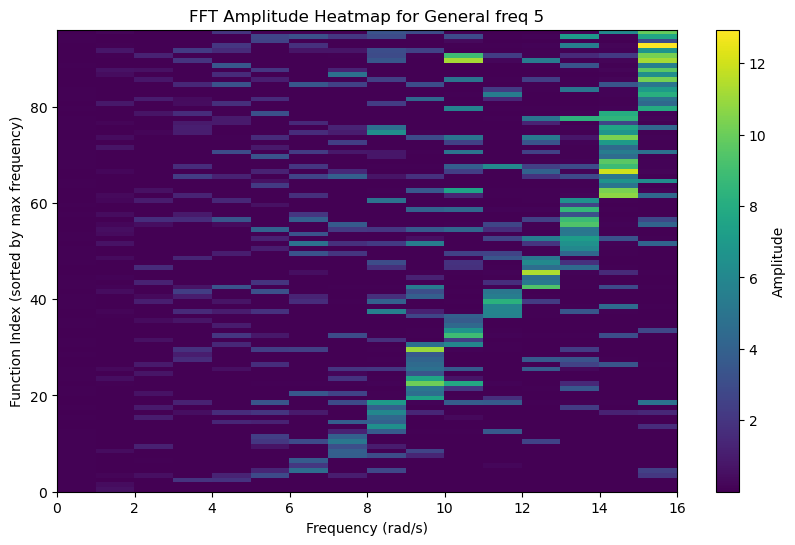

Epoch [7/500], Train Loss: 18.3124, Test Loss: 20.2639
Plotting the colormap once at iteration 6
Showing residues
Showing residues
Showing residues


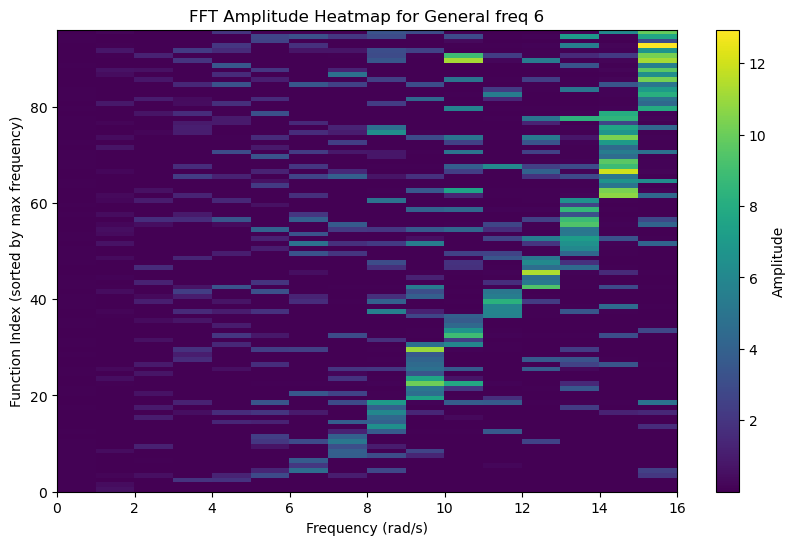

Epoch [8/500], Train Loss: 18.4469, Test Loss: 20.2595
Plotting the colormap once at iteration 7
Showing residues
Showing residues
Showing residues


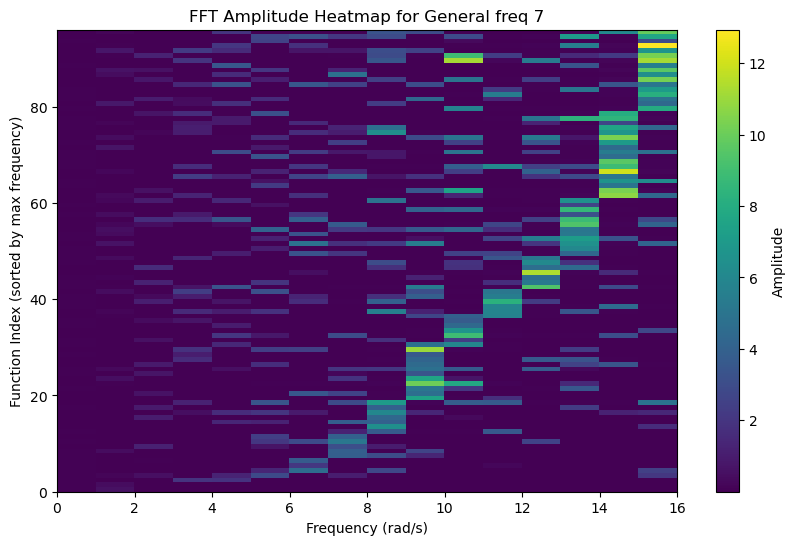

Epoch [9/500], Train Loss: 18.2025, Test Loss: 20.2550
Plotting the colormap once at iteration 8
Showing residues
Showing residues
Showing residues


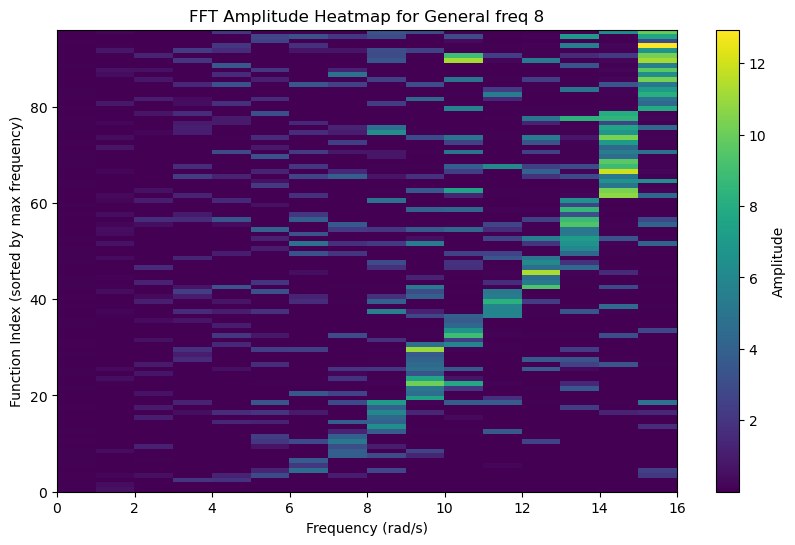

Epoch [10/500], Train Loss: 18.5337, Test Loss: 20.2502
Plotting the colormap once at iteration 9
Showing residues
Showing residues
Showing residues


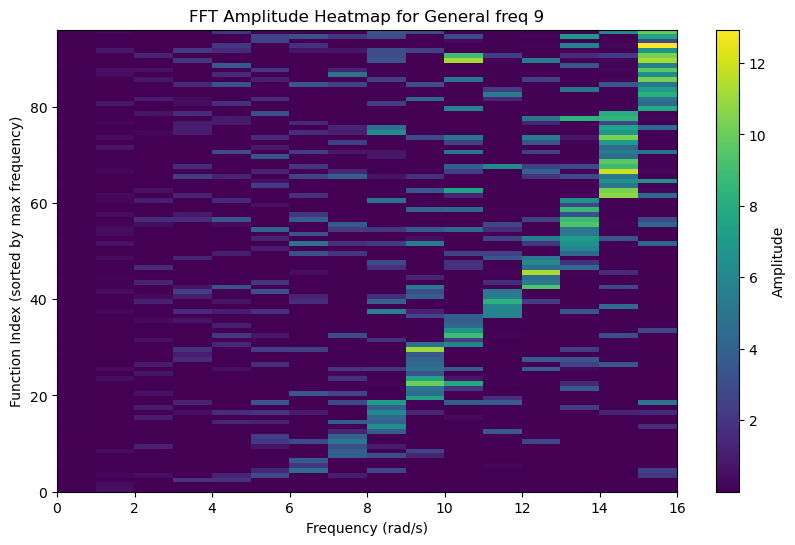

Epoch [11/500], Train Loss: 18.3471, Test Loss: 20.2456
Plotting the colormap once at iteration 10
Showing residues
Showing residues
Showing residues


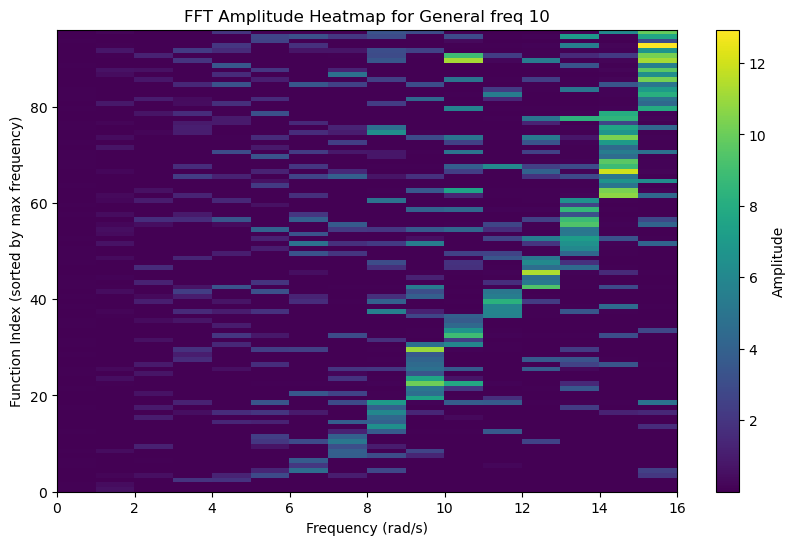

Epoch [12/500], Train Loss: 18.4033, Test Loss: 20.2411
Plotting the colormap once at iteration 11
Showing residues
Showing residues
Showing residues


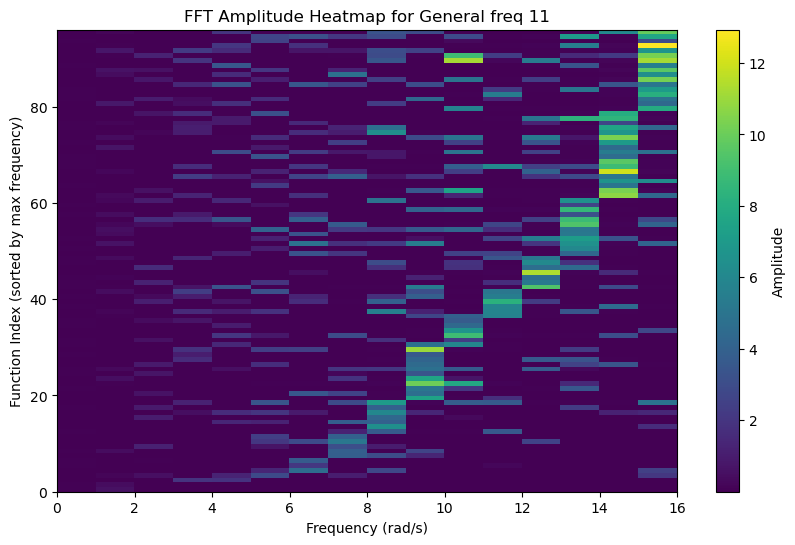

Epoch [13/500], Train Loss: 18.3363, Test Loss: 20.2365
Plotting the colormap once at iteration 12
Showing residues
Showing residues
Showing residues


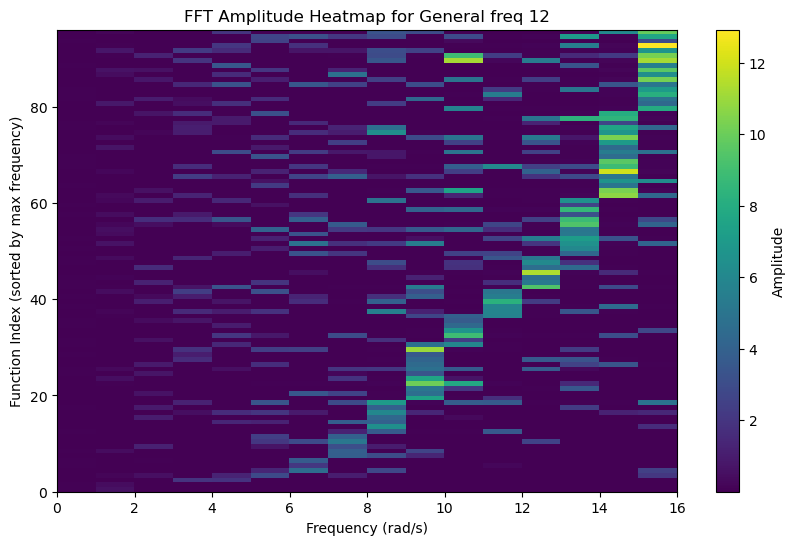

Epoch [14/500], Train Loss: 18.2765, Test Loss: 20.2319
Plotting the colormap once at iteration 13
Showing residues
Showing residues
Showing residues


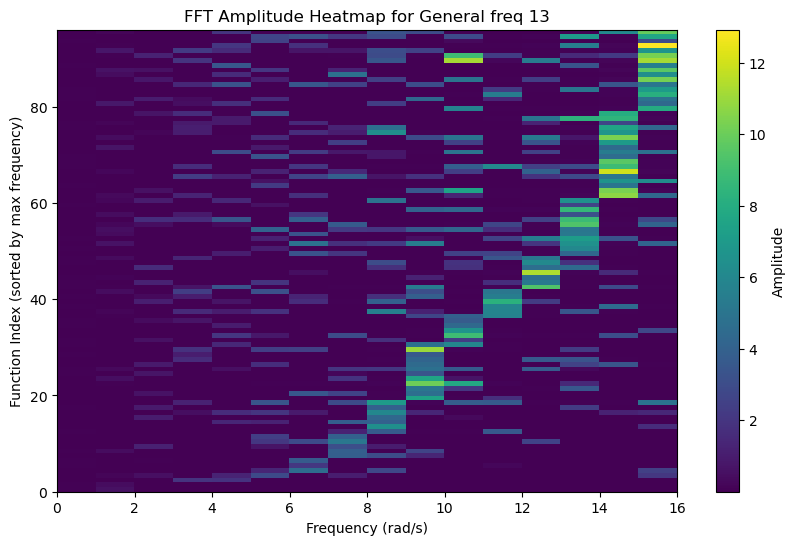

Epoch [15/500], Train Loss: 18.4458, Test Loss: 20.2273
Plotting the colormap once at iteration 14
Showing residues
Showing residues
Showing residues


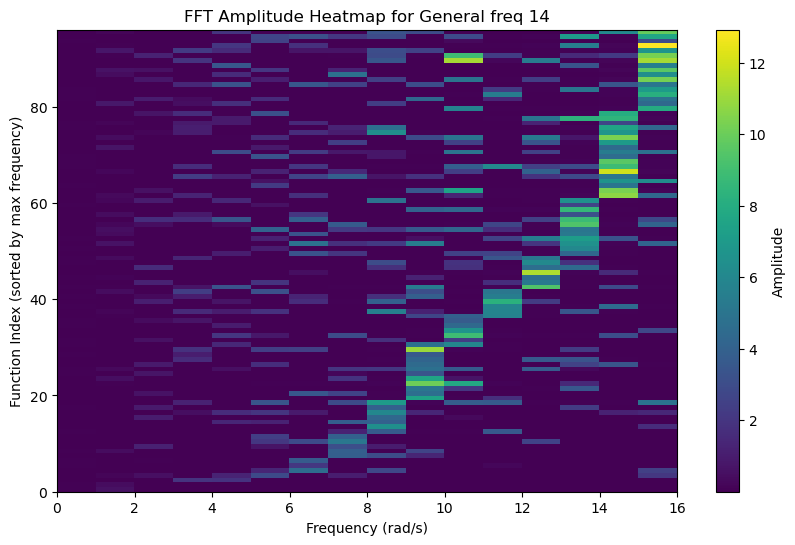

Epoch [16/500], Train Loss: 17.7067, Test Loss: 20.2227
Plotting the colormap once at iteration 15
Showing residues
Showing residues
Showing residues


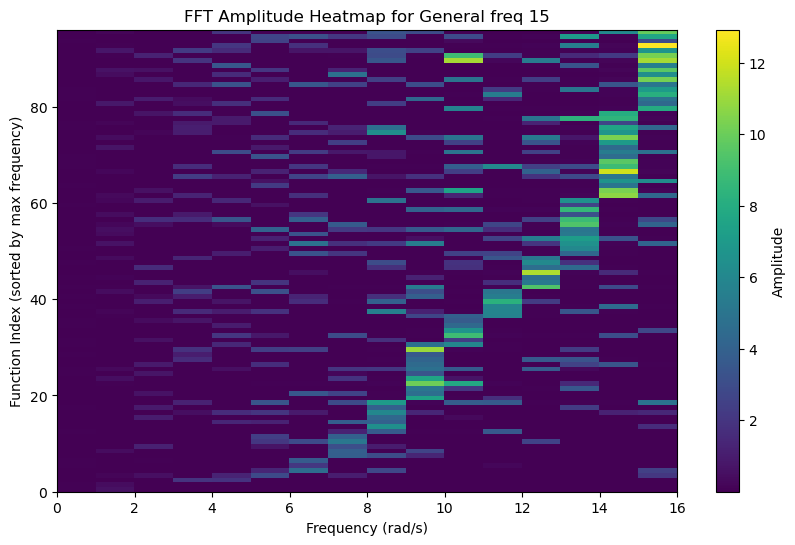

Epoch [17/500], Train Loss: 18.3876, Test Loss: 20.2175
Plotting the colormap once at iteration 16
Showing residues
Showing residues
Showing residues


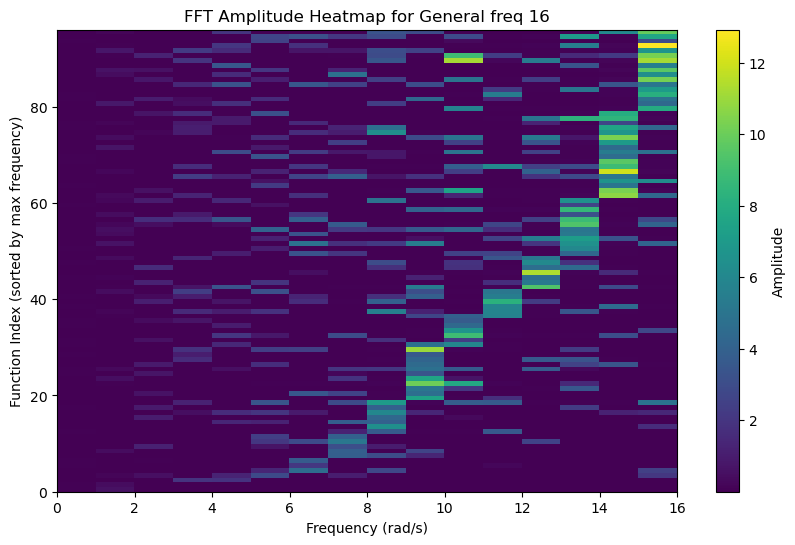

Epoch [18/500], Train Loss: 18.2404, Test Loss: 20.2125
Plotting the colormap once at iteration 17
Showing residues
Showing residues
Showing residues


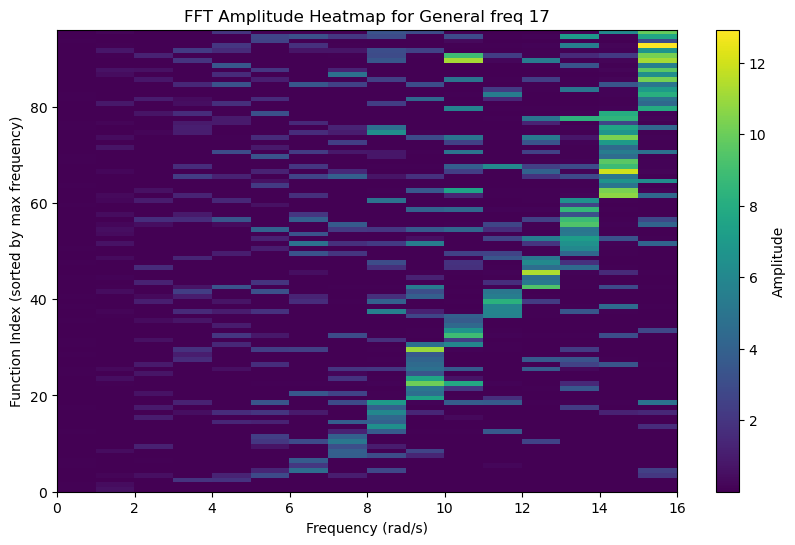

Epoch [19/500], Train Loss: 18.4064, Test Loss: 20.2072
Plotting the colormap once at iteration 18
Showing residues
Showing residues
Showing residues


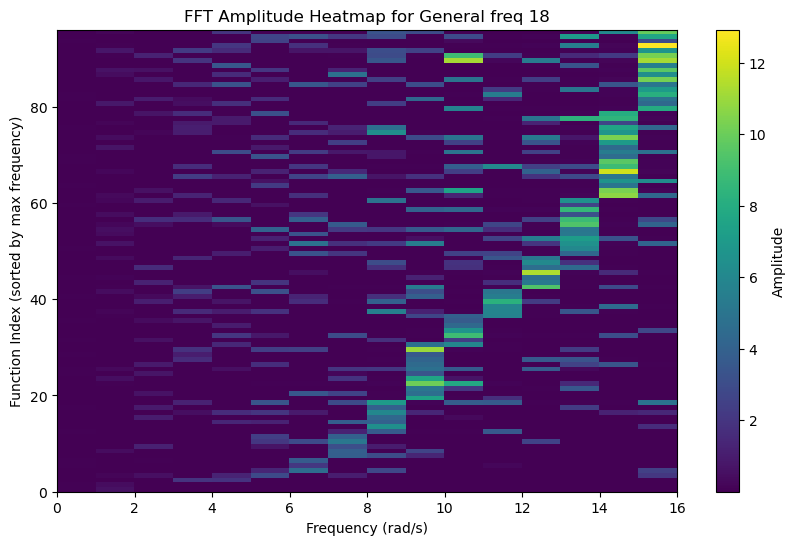

KeyboardInterrupt: 

In [160]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training_plots(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=500, split_freq=500, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', residue=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Experiments with training on different datasets

3 layers, kernel size 3

### Training on low frequency dataset only

In [ ]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

# train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
#     num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first', nmse=True)
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print_metrics(L3ModelK3_low)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9992063641548157
NMSE over high freq test functions: 0.9992488622665405


In [ ]:
(0.08218340575695038 - 0.001168005052022636) / 0.001168005052022636

69.36220058691806